# Initializing Dash for visualization

## imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from PIL import Image
from jupyter_dash import JupyterDash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import csv 

## get all the teams

In [2]:
sys.path.insert(0,'../src/data/')
from team_data import  get_all_teams 

seasons = [2016, 2017, 2018, 2019, 2020]    
game_data_dir = "../data/games/"

fname = "../data/NHL_Teams_List.csv"
img = Image.open('../figures/nhl_rink.png')

# for the binning
grid_size = 300
min_count = 3 

if os.path.isfile(fname):
    teams_lst_df=pd.read_csv(fname)
    teams_lst = teams_lst_df['Teams'].values.tolist()
else:
    teams_lst = get_all_teams(data_dir="../data/raw")
    teams_lst_df = pd.DataFrame(teams_lst,columns =['Teams'])
    teams_lst_df.to_csv(fname)

## Adding the NHL rink as background image for any plotly graph

In [3]:
def add_nhl_rink_img(fig):
        # set the axes
    fig.update_yaxes(range=[-45, 45], 
                     scaleratio = 1, 
                     scaleanchor="y",
                     showgrid=True,
                     zeroline=True,
                     showline=True,
                     gridcolor='#bdbdbd',
                     gridwidth=2,
                     zerolinecolor='#969696',
                     zerolinewidth=4,
                     linecolor='#636363',
                     linewidth=6)
    fig.update_xaxes(range=[-100, 100], 
                     scaleratio = 1, 
                     scaleanchor="x",
                     showgrid=True,
                     zeroline=True,
                     showline=True,
                     gridcolor='#bdbdbd',
                     gridwidth=2,
                     zerolinecolor='#969696',
                     zerolinewidth=4,
                     linecolor='#636363',
                     linewidth=6)

    # remove any margins and padding
    fig.update_layout(
        autosize=False,
        width=1000,
        height=500,
        margin=dict(l=0, #left margin
                    r=0, #right margin
                    b=0, #bottom margin
                    t=0,  #top margin
                    pad=0
                   )
    )


    # Add the NHL rink image
    fig.add_layout_image(
            dict(
                source=img,
                xref="x",
                yref="y",
                x=0,
                y=0,
                sizex=200,
                sizey=85,
                sizing= "stretch",
                layer = "below",
                xanchor = "center",
                yanchor = "middle",
                opacity = 0.8),
    )
    return fig

## Bin a given dataframe for the NHL rink

In [4]:
def get_bins(df):
    xbnds = np.array([-100., 100.0])
    ybnds = np.array([-42.5, 42.5])
    extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
    
    league_hex_data = plt.hexbin(df['coordinate_x'],df['coordinate_y'], 
                                 gridsize=grid_size,
                                 extent=extent,
                                 mincnt=min_count,
                                 alpha=0.0)# Now we extract the bin coordinates and counts
    league_bins = league_hex_data.get_offsets();
    league_shot_frequency = league_hex_data.get_array();
    return league_bins, league_shot_frequency

## Prepare the layout: adding slider and two dropdown lists 

In [5]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    
    html.Div([
        "Team: ",
        dcc.Dropdown(
                    id='teams-dropdown',
                    options=[{'label': i, 'value': i} for i in teams_lst],
                    value=teams_lst[0]
                ),
        "Season: ",
        dcc.Dropdown(
                    id='seasons-dropdown',
                    options=[{'label': i, 'value': str(i)} for i in seasons],
                    value=seasons[0]
                ),
        "Sub-season: ",
        dcc.Dropdown(
                    id='sub-seasons-dropdown',
                    options=[{'label': i, 'value': i} for i in ['regular', 'postseason']],
                    value='regular'
                ),
        ],
        style={'width': '49%', 'display': 'inline-block'}),
    
    html.Div([
        "Shots and Goals Map: ",
        dcc.Graph(id='nhl-rink-graph'),
        "League Average: ",
        dcc.Graph(id='nhl-league-avg-graph'),
        "Team Excess Shots per Spatial Location: ",
        dcc.Graph(id='nhl-team-excess-shots-graph'),
    ])
])

## Visualizing the shots for a given team, year and season

[source](https://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d)

In [6]:
def get_league_avg_fig(game_df):
    
    # get the bins of the x and y coordinates
    league_bins, league_bin_counts = get_bins(game_df)
        
    # divide the counts by the number of teams in the selected season (to get league averages)
    teams_in_season = set(game_df['home_team'].unique() + game_df['away_team'].unique())
    num_teams = len(teams_in_season)
    league_bin_avg = league_bin_counts/float(num_teams)    
    
    bin_dct = {'x': league_bins[:,0], 'y': league_bins[:,1], 'league_avg': league_bin_avg}
    new_binned_df = pd.DataFrame(bin_dct)
    

    
    # hex/density figure
    fig_bin = px.density_heatmap(new_binned_df, x="x", y="y", z="league_avg", color_continuous_scale="turbo")
    fig_bin.update_traces(zsmooth='ḅest', selector=dict(type='heatmap'))
    fig_bin.update_traces(connectgap=True, selector=dict(type='heatmap'))
    fig_bin.update_traces(opacity=0.5)
    fig_bin.add_trace(fig_bin.data[0])

    fig_bin = add_nhl_rink_img(fig_bin)
    
    return fig_bin, league_bins, league_bin_avg

In [7]:
def get_team_excess_shot_fig(team_bin_df, league_bins, league_bin_avg):
       
    # get the bins of the x and y coordinates
    team_bins, team_bin_counts = get_bins(team_bin_df)
    
    # calculate the excess shots per location (x,y) 
    # (i.e. the difference between the team_bin_counts and league_bin_avg)
    
    num_bins = len(team_bin_counts)
    
    team_excess_shots = np.zeros(num_bins)
    
    for idx_team, team_bin in enumerate(team_bins):
        for idx_league, league_bin in enumerate(league_bins):
            if team_bin[0] == league_bin[0] and team_bin[1] == league_bin[1]:
                team_excess_shots[idx_team] = team_bin_counts[idx_team] - league_bin_avg[idx_league]

    print(team_excess_shots)
    bin_dct = {'x': team_bins[:,0], 'y': team_bins[:,1], 'excess_shots': team_excess_shots}
    new_binned_df = pd.DataFrame(bin_dct)
    
    
    # hex/density figure
    fig_bin = px.density_heatmap(new_binned_df, x="x", y="y", z="excess_shots", color_continuous_scale="turbo")
    fig_bin.update_traces(zsmooth='best', selector=dict(type='heatmap'))
    fig_bin.update_traces(connectgap=True, selector=dict(type='heatmap'))

    fig_bin.update_traces(opacity=0.5)
    try:
        fig_bin.add_trace(fig_bin.data[0])
        fig_bin = add_nhl_rink_img(fig_bin)
    except:
        fig_bin = add_nhl_rink_img(fig_bin)

    return fig_bin, team_bins, team_bin_counts

In [8]:
@app.callback(
    Output('nhl-rink-graph', 'figure'),
    Output('nhl-league-avg-graph', 'figure'),
    Output('nhl-team-excess-shots-graph', 'figure'),
    [Input('seasons-dropdown', 'value'),
     Input('teams-dropdown', 'value'),
     Input('sub-seasons-dropdown', 'value')])
def update_figure(selected_season, selected_team, selected_sub_season):
    
    # get the dataframe of the chosen team
    if selected_sub_season == 'regular':
        sub_str = '02'
    elif selected_sub_season == 'postseason':
        sub_str = '03'

    game_file_str = str(selected_season) + '-' + selected_sub_season + '.csv'
    game_df = pd.read_csv(os.path.join(game_data_dir, game_file_str))
    
    # team's data
    team_df = game_df[game_df['shooter_team_name'] == selected_team]
    
    fig = px.scatter(team_df, x="coordinate_x", y="coordinate_y", 
                              color="type", hover_name="shooter_name")
    
    fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,)),
                  selector=dict(mode='markers'))
    
    fig = add_nhl_rink_img(fig)

    ############# calculate the league averages ###########
    fig_league_avg, league_bins, league_bin_avg = get_league_avg_fig(game_df)
    ############# get each team's excess shots per location ###########
    fig_team_excess_shot, team_bins, team_bin_counts = get_team_excess_shot_fig(team_df, 
                                                                                league_bins, 
                                                                                league_bin_avg)
    
    return fig, fig_league_avg, fig_team_excess_shot

app.run_server()

Dash app running on http://127.0.0.1:8050/
[ 2.26666667  2.33333333  2.56666667  2.63333333  2.16666667  2.56666667
  3.3         2.13333333  2.3         2.5         2.43333333  2.3
  2.26666667  2.2         2.3         3.3         2.06666667  2.23333333
  2.2         3.3         3.06666667  2.03333333  2.23333333  3.16666667
  2.1         2.36666667  1.36666667  0.56666667  0.5         1.4
  2.2         2.93333333  4.53333333  2.63333333  2.23333333  4.13333333
  2.2         2.23333333  0.16666667  0.73333333  1.6         0.63333333
  4.6         3.9         3.26666667  2.63333333  1.83333333  1.86666667
  2.46666667  2.23333333  1.83333333  2.96666667  2.36666667  3.16666667
  2.36666667  2.3         2.36666667  2.13333333  2.53333333  2.43333333
  2.36666667  3.          2.36666667  2.43333333  3.46666667  1.9
  2.36666667  2.73333333  2.46666667  2.06666667  3.2         1.9
  2.6         0.96666667  0.8         1.43333333  1.43333333  2.43333333
  2.2         1.46666667  2.33333333

# Draft

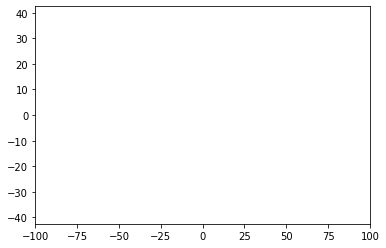

In [26]:
game_df = pd.read_csv("../data/games_year/2016.csv")
team_df = game_df[game_df['shooter_team_name'] == teams_lst[0]]

positions: (4768,)
depth: (4768,)


ValueError: points have dimension 2, dataset has dimension 1

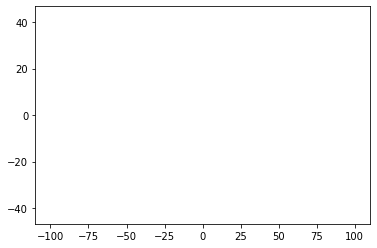

In [64]:
############# calculate the league averages ###########
fig_league_avg, league_bins, league_bin_counts = get_league_avg_fig(game_df)
############# get each team's excess shots per location ###########
fig_team_excess_shot, team_bins, team_bin_counts = get_team_excess_shot_fig(team_df, league_bins, league_bin_counts)
league_bins[:,0].shape

In [22]:
league_bins.shape, team_bins.shape

((3001, 2), (89, 2))

In [29]:
cnt = 0
for team_bin in team_bins:
    for league_bin in league_bins:
        if team_bin[0] == league_bin[0] and team_bin[1] == league_bin[1]:
            # print(team_bin)
            # print(league_bin)
            cnt += 1
cnt

89

In [23]:
league_bins[0], team_bins[0]

(array([-1.42108547e-14, -2.23684211e+00]),
 array([ 36.00000007, -29.07894737]))

In [61]:
def measure(n):

    "Measurement model, return two coupled measurements."

    m1 = np.random.normal(size=n)

    m2 = np.random.normal(scale=0.5, size=n)

    return m1+m2, m1-m2

m1, m2 = measure(2000)

xmin = m1.min()

xmax = m1.max()

ymin = m2.min()

ymax = m2.max()

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
print(X.shape)
positions = np.vstack([X.ravel(), Y.ravel()])
positions[0].shape
values = np.vstack([m1, m2])
print(values.shape)
# kernel = stats.gaussian_kde(values)

# Z = np.reshape(kernel(positions).T, X.shape)

(100, 100)
(2, 2000)


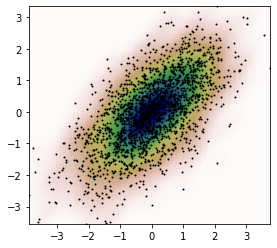

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,

          extent=[xmin, xmax, ymin, ymax])

ax.plot(m1, m2, 'k.', markersize=2)

ax.set_xlim([xmin, xmax])

ax.set_ylim([ymin, ymax])

plt.show()
